<a href="https://colab.research.google.com/github/RadSpiral/certified_machine_unlearning/blob/main/IMDB_reviews_example_m_scaling_ridge_logistic_machine_unlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
from scipy.sparse import hstack, csr_matrix

# Download NLTK data
nltk.download('stopwords')

# Download and Load IMDb dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.decode('utf-8')
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Extract X and y from train and test datasets
X_train_list = [preprocess(text.numpy()) for text, _ in train_dataset]
y_train = [label.numpy() for _, label in train_dataset]
X_test_list = [preprocess(text.numpy()) for text, _ in test_dataset]
y_test = [label.numpy() for _, label in test_dataset]

print("Train Sample Size:", len(X_train_list))
print("Test Sample Size:", len(X_test_list))

# Vectorization of text data
vectorizer = CountVectorizer(
    max_features=100000,   # keep top frequent terms
    min_df=10,             # ignore words that appear in fewer than min_df documents
    max_df=0.1,            # ignore words that appear in >10% of documents
    stop_words='english'   # remove stop words
)

X_train = vectorizer.fit_transform(X_train_list)
X_test = vectorizer.transform(X_test_list)

# Add intercept column (bias term)
n_train, p = X_train.shape
n_test = X_test.shape[0]

intercept_train = np.ones((n_train, 1))
intercept_test = np.ones((n_test, 1))

X_train = hstack([csr_matrix(intercept_train), X_train]).tocsr()
X_test = hstack([csr_matrix(intercept_test), X_test]).tocsr()

# Print results
print("Shape of X_train_vect (with intercept):", X_train.shape)
print("Shape of X_test_vect (with intercept):", X_test.shape)
print("Vocabulary Size:", len(vectorizer.vocabulary_))

# Define n and p for downstream use
n, p = X_train.shape
print(f"n = {n}, p = {p}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train Sample Size: 25000
Test Sample Size: 25000
Shape of X_train_vect (with intercept): (25000, 12610)
Shape of X_test_vect (with intercept): (25000, 12610)
Vocabulary Size: 12609
n = 25000, p = 12610


Avg nonzero features per row — train: 62.38
Avg nonzero features per row — test:  60.34


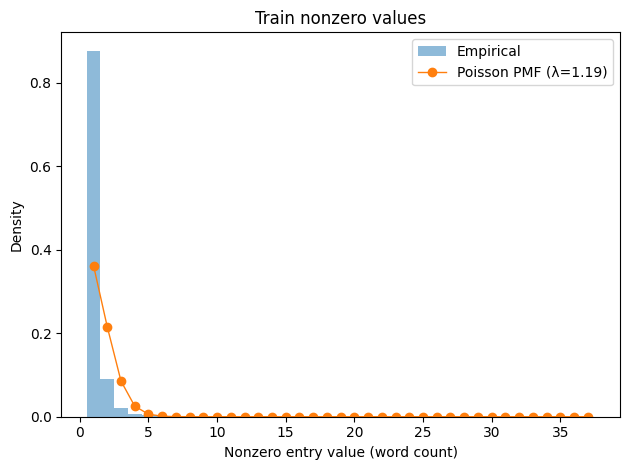

Train nonzero values — mean of nonzero entries (λ MLE): 1.190


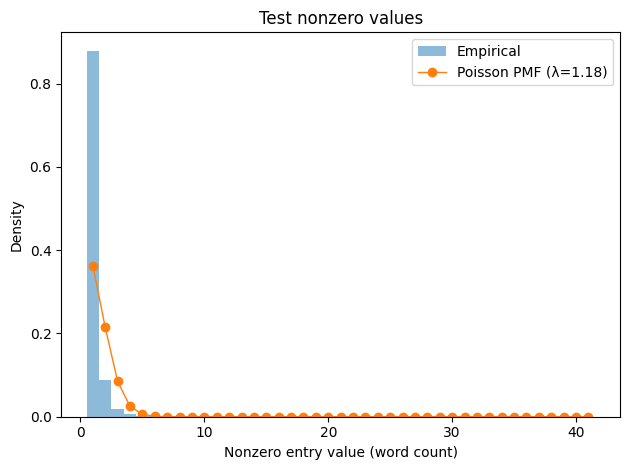

Test nonzero values — mean of nonzero entries (λ MLE): 1.183


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

def avg_nnz_per_row(X):
    return X.getnnz(axis=1).mean()

def plot_nonzero_value_hist_with_poisson(X, title):
    v = X.data  # all nonzero entries
    lam = v.mean()  # MLE for Poisson
    # integer bins centered on counts
    v_min, v_max = int(v.min()), int(v.max())
    bins = np.arange(v_min - 0.5, v_max + 1.5, 1)

    plt.figure()
    plt.hist(v, bins=bins, density=True, alpha=0.5, edgecolor='none', label='Empirical')
    ks = np.arange(v_min, v_max + 1)
    pmf = poisson.pmf(ks, mu=lam)
    plt.plot(ks, pmf, marker='o', linewidth=1, label=f'Poisson PMF (λ={lam:.2f})')
    plt.xlabel('Nonzero entry value (word count)')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"{title} — mean of nonzero entries (λ MLE): {lam:.3f}")

# 1) Average % of nonzeros per row
avg_nnz_train = avg_nnz_per_row(X_train)
avg_nnz_test  = avg_nnz_per_row(X_test)
print(f"Avg nonzero features per row — train: {avg_nnz_train:.2f}")
print(f"Avg nonzero features per row — test:  {avg_nnz_test:.2f}")

# 2) Histogram of all nonzero values with fitted Poisson
plot_nonzero_value_hist_with_poisson(X_train, 'Train nonzero values')
plot_nonzero_value_hist_with_poisson(X_test,  'Test nonzero values')


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import laplace, norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, issparse
from scipy.sparse.linalg import cg, LinearOperator

# Logistic Ridge Regression Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(beta, X, y, lambda_):
    z = X @ beta
    # log(1+exp(z)) = softplus(z) via logaddexp
    nll = -(y * z - np.logaddexp(0.0, z)).sum()
    ridge = 0.5 * lambda_ * np.sum(beta**2)
    return nll + ridge

def gradient(beta, X, y, lambda_):
    p = sigmoid(X @ beta)
    return -X.T @ (y - p) + lambda_ * beta

def hessian(beta, X, lambda_):
    p = sigmoid(X @ beta)
    w = p * (1 - p)                             # shape (n,)
    XTWX = (X * w[:, None]).T @ X               # p×p
    return XTWX + lambda_ * np.eye(X.shape[1])

def newton_step(beta_init, X, y, lambda_, tol=1e-6, max_iter=100):
    beta = beta_init.copy()
    for step_count in range(1, max_iter + 1):
        grad = gradient(beta, X, y, lambda_)
        hess = hessian(beta, X, lambda_)
        step = np.linalg.solve(hess, grad)
        beta -= step
        if np.linalg.norm(step) < tol:
            return beta, step_count
    return beta, max_iter

def make_Hv(beta, X, lambda_):
    # returns LinearOperator v -> (X^T W X + λI) v  with W=diag(p*(1-p))
    z = X @ beta
    w = sigmoid(z) * (1 - sigmoid(z))           # shape (n,)
    if not issparse(X): X = csr_matrix(X)
    d = X.shape[1]
    def mv(v):
        t = X @ v            # n,
        u = w * t            # n,
        return X.T @ u + lambda_ * v   # d,
    return LinearOperator((d, d), matvec=mv, dtype=np.float64)

def newton_step_cg(beta_init, X, y, lambda_, tol=1e-6, max_iter=100, cg_tol=1e-6, cg_maxit=None):
    beta = beta_init.astype(np.float64).copy()
    if not issparse(X): X = csr_matrix(X)

    for k in range(max_iter):
        dL = gradient(beta, X, y, lambda_)
        G  = make_Hv(beta, X, lambda_)
        # solve (H) s = g  via CG (no preconditioner)
        s, info = cg(G, dL, rtol=cg_tol, maxiter=cg_maxit)
        if info != 0:  # non-convergence or breakdown
            # fallback to damped gradient step
            s = dL
        beta -= s
        if np.linalg.norm(s) < tol:
            return beta, k+1
    return beta, max_iter

def hutch_trace_AinvB(beta, X, lam, r=5, rtol=1e-4, maxit=500, seed=0):
    # precompute w and define HVP for A
    z_full = X @ beta
    p = 1.0 / (1.0 + np.exp(-z_full))
    w = p * (1 - p)  # shape (n,)

    if not issparse(X):
        X = csr_matrix(X)
    d = X.shape[1]

    # A*v = X^T (w * (X v)) + lam*v
    def A_mv(v):
        return X.T @ (w * (X @ v)) + lam * v
    A = LinearOperator((d, d), matvec=A_mv, dtype=np.float64)

    # B*z = X^T (w * (X z))
    def Bz_mv(z):
        return X.T @ (w * (X @ z))

    rng = np.random.default_rng(seed)
    # Rademacher probes are standard
    Z = rng.choice([-1.0, 1.0], size=(r, d))

    est = 0.0
    for i in range(r):
        z = Z[i]
        bz = Bz_mv(z)
        s, info = cg(A, bz, rtol=rtol, maxiter=maxit)
        if info != 0:  # fallback if CG fails
            # use a few extra iters or looser tol if needed
            s, _ = cg(A, bz, rtol=1e-3, maxiter=2*maxit)
        est += z @ s   # z^T (A^{-1} B z)

    return est / r


# Set seed for reproducibility
np.random.seed(1)

n, p = X_train.shape
X    = X_train.toarray()
y    = np.array(y_train)
# Parameters
#n = 1800  # Fixed sample size
#p = 2000  # Fixed number of features
MCMCsamples = 1 #100
lambda_ = 100  # Regularization constant
cg_tol = 1e-6
cg_maxit = 10000
# Generate data and fit model
m_max = 4000
m_values = np.unique(np.logspace(1, np.log10(m_max), num=10, dtype=int))

# Initialize storage arrays
error_means_tilde = np.zeros(len(m_values))
error_stds_tilde = np.zeros(len(m_values))
error_means_tilde_2 = np.zeros(len(m_values))
error_stds_tilde_2 = np.zeros(len(m_values))
error_means_hat = np.zeros(len(m_values))
error_stds_hat = np.zeros(len(m_values))

for s in range(MCMCsamples):
    #beta_star = np.random.normal(0, 1, p)
    #X = np.random.normal(0, 1 / np.sqrt(n), (n, p))
    #logits = X @ beta_star
    #prob = sigmoid(logits)
    #y = np.random.binomial(1, prob)

    beta_init = np.random.normal(0, 1, p) * 0.01
    # Compute Newton steps for beta_hat
    beta_hat, steps_used = newton_step_cg(beta_init, X, y, lambda_)

    # Compute hat matrix H
    #p_hat = sigmoid(X @ beta_hat)
    #W = np.diag(p_hat * (1 - p_hat))
    #hess_inv = np.linalg.inv(hessian(beta_hat, X, lambda_))
    #H = X @ hess_inv @ X.T @ W
    #tr_H = np.trace(H) / p
    #print(f"---------------- s = {s}, df = {tr_H:.2f}, lambda = {lambda_}, n = {n}, p = {p}, Newton Steps: {steps_used} ----------------")

    # usage: fast dof estimate (no inverses, no n×n)
    p_hat = sigmoid(X @ beta_hat)
    tr_H_est = hutch_trace_AinvB(beta_hat, X, lambda_, r=1, rtol=1e-4, maxit=500) / p
    print(f"---------------- s = {s}, df = {tr_H_est:.2f}, lambda = {lambda_}, n = {n}, p = {p}, Newton Steps: {steps_used} ----------------")

    #print(f"---------------- s = {s}, "
     # f"df_exact = {tr_H:.4f}, "
     # f"df_est = {tr_H_est:.4f}, "
     # f"Δ = {abs(tr_H - tr_H_est):.3e}, "
     # f"λ = {lambda_}, n = {n}, p = {p}, Newton Steps: {steps_used} ----------------")

    # Compute predictions and errors on train and test sets
    p_train = sigmoid(X @ beta_hat)
    y_pred_train = (p_train >= 0.5).astype(int)
    train_error = np.mean(y_pred_train != y)

    # test set
    X_test_arr = X_test.toarray()
    y_test_arr = np.array(y_test)
    p_test = sigmoid(X_test_arr @ beta_hat)
    y_pred_test = (p_test >= 0.5).astype(int)
    test_error = np.mean(y_pred_test != y_test_arr)

    print(f"Train error = {train_error:.3f}, Test error = {test_error:.3f}")


    errors_tilde, errors_tilde_2, errors_hat = [], [], []

    for m in m_values:
        iM = np.random.choice(n, size=m, replace=False)
        X_M, y_M = X[iM], y[iM]
        iMc = np.setdiff1d(np.arange(n), iM)
        X_Mc, y_Mc = X[iMc], y[iMc]

        beta_init = np.random.normal(0, 1, p) * 0.01
        beta_hat_M_out, steps_used = newton_step_cg(beta_init, X_Mc, y_Mc, lambda_)

        # Compute beta_tilde_m_out
        G_Mc             = make_Hv(beta_hat, X_Mc, lambda_)
        dL_Mc            = gradient(beta_hat, X_Mc, y_Mc, lambda_)
        ddelta_1, info   = cg(G_Mc, dL_Mc, rtol=cg_tol, maxiter=cg_maxit)
        beta_tilde_m_out = beta_hat - ddelta_1

        # Compute beta_tilde_m_out
        #diag_l_M = np.diag(p_hat[iM] * (1 - p_hat[iM]))
        #E_M = hess_inv @ X_M.T
        #H_M = diag_l_M @ X_M @ E_M
        #l_dot_M = p_hat[iM] - y_M
        #ddelta_1_ = E_M @ np.linalg.inv(np.eye(m) - H_M) @ l_dot_M

        # Diagnostics
        #print(f"‖ddelta_1‖      = {np.linalg.norm(ddelta_1):.3e}, "
         # f"‖ddelta_1'‖     = {np.linalg.norm(ddelta_1_):.3e}, "
         # f"‖ddelta_1 - ddelta_1'‖ = {np.linalg.norm(ddelta_1 - ddelta_1_):.3e}, "
         # f"‖beta_hat‖ = {np.linalg.norm(beta_hat):.3e}, "
         # f"CG info = {info}")

        #beta_tilde_m_out = beta_hat + E_M @ np.linalg.inv(np.eye(m) - H_M) @ l_dot_M

        # Compute beta_tilde_m_out_2
        G_Mc_2             = make_Hv(beta_tilde_m_out, X_Mc, lambda_)
        dL_Mc_2            = gradient(beta_tilde_m_out, X_Mc, y_Mc, lambda_)
        ddelta_2, info     = cg(G_Mc_2, dL_Mc_2, rtol=cg_tol, maxiter=cg_maxit)
        beta_tilde_m_out_2 = beta_tilde_m_out - ddelta_2

        # Compute beta_tilde_m_out_2
        #hess_Mc_tilde = hessian(beta_tilde_m_out, X_Mc, lambda_)
        #grad_Mc_tilde = gradient(beta_tilde_m_out, X_Mc, y_Mc, lambda_)
        #beta_tilde_m_out_2 = beta_tilde_m_out - np.linalg.solve(hess_Mc_tilde, grad_Mc_tilde)

        # Compute errors
        errors_tilde.append(np.linalg.norm(beta_hat_M_out - beta_tilde_m_out))
        errors_tilde_2.append(np.linalg.norm(beta_hat_M_out - beta_tilde_m_out_2))
        errors_hat.append(np.linalg.norm(beta_hat_M_out - beta_hat))

        # Linear regression log(error) vs log(m)
        if len(errors_tilde) > 2:
          log_m = np.log(m_values[:len(errors_tilde)])
          X_reg = sm.add_constant(log_m)
          def fit_model(errors):
            return sm.OLS(np.log(errors), X_reg).fit()
          models = {
                "tilde": fit_model(errors_tilde),
                "tilde_2": fit_model(errors_tilde_2),
                "hat": fit_model(errors_hat),
          }
          results = {
                name: {
                    "slope": model.params[1],
                    "conf_int": model.conf_int()[1],
                    "R2": model.rsquared,
                }
                for name, model in models.items()
          }
          print(f"    m = {m:>4d}: "
              f"|b_tilde_M - b_hat_M| = {errors_tilde[-1]:.2f}, slope = {results['tilde']['slope']:.2f}, "
              f"CI = ({results['tilde']['conf_int'][0]:6.2f}, {results['tilde']['conf_int'][1]:6.2f}), R² = {results['tilde']['R2']:.2f} | "
              f"|b_tilde_M_2 - b_hat_M| = {errors_tilde_2[-1]:.2f}, slope = {results['tilde_2']['slope']:.2f}, "
              f"CI = ({results['tilde_2']['conf_int'][0]:6.2f}, {results['tilde_2']['conf_int'][1]:6.2f}), R² = {results['tilde_2']['R2']:.2f} | "
              f"|b_hat - b_hat_M| = {errors_hat[-1]:.1f}, slope = {results['hat']['slope']:.2f}, "
              f"CI = ({results['hat']['conf_int'][0]:6.2f}, {results['hat']['conf_int'][1]:6.2f}), R² = {results['hat']['R2']:.2f} |")



    # Incremental mean update
    delta = np.array(errors_tilde) - error_means_tilde
    error_means_tilde += delta / (s + 1)

    # Incremental variance update (Welford’s method)
    error_stds_tilde = np.sqrt((s * error_stds_tilde**2 + delta * (np.array(errors_tilde) - error_means_tilde)) / (s + 1))

    # Repeat for tilde_2 and hat variables
    delta_2 = np.array(errors_tilde_2) - error_means_tilde_2
    error_means_tilde_2 += delta_2 / (s + 1)
    error_stds_tilde_2 = np.sqrt((s * error_stds_tilde_2**2 + delta_2 * (np.array(errors_tilde_2) - error_means_tilde_2)) / (s + 1))

    delta_hat = np.array(errors_hat) - error_means_hat
    error_means_hat += delta_hat / (s + 1)
    error_stds_hat = np.sqrt((s * error_stds_hat**2 + delta_hat * (np.array(errors_hat) - error_means_hat)) / (s + 1))


    # Print final results
    error_table = pd.DataFrame({
      'm': m_values,
      'Mean Error Tilde': np.round(error_means_tilde, 3),
      'SD Tilde': np.round(error_stds_tilde, 3),
      'Mean Error Tilde_2': np.round(error_means_tilde_2, 3),
      'SD Tilde_2': np.round(error_stds_tilde_2, 3),
      'Mean Error Hat': np.round(error_means_hat, 3),
      'SD Hat': np.round(error_stds_hat, 3)
      })

    print(error_table.to_string(index=False))




---------------- s = 0, df = 0.12, lambda = 100, n = 25000, p = 12610, Newton Steps: 6 ----------------
Train error = 0.098, Test error = 0.143
    m =   37: |b_tilde_M - b_hat_M| = 0.00, slope = 1.14, CI = ( -4.04,   6.31), R² = 0.89 | |b_tilde_M_2 - b_hat_M| = 0.00, slope = 3.04, CI = ( -4.04,  10.13), R² = 0.97 | |b_hat - b_hat_M| = 0.1, slope = 0.35, CI = ( -3.20,   3.91), R² = 0.62 |
    m =   73: |b_tilde_M - b_hat_M| = 0.00, slope = 1.31, CI = (  0.43,   2.20), R² = 0.95 | |b_tilde_M_2 - b_hat_M| = 0.00, slope = 3.23, CI = (  2.08,   4.38), R² = 0.99 | |b_hat - b_hat_M| = 0.1, slope = 0.51, CI = ( -0.14,   1.17), R² = 0.85 |
    m =  143: |b_tilde_M - b_hat_M| = 0.00, slope = 1.11, CI = (  0.57,   1.64), R² = 0.94 | |b_tilde_M_2 - b_hat_M| = 0.00, slope = 2.40, CI = (  0.82,   3.98), R² = 0.89 | |b_hat - b_hat_M| = 0.2, slope = 0.55, CI = (  0.27,   0.84), R² = 0.93 |
    m =  278: |b_tilde_M - b_hat_M| = 0.00, slope = 0.99, CI = (  0.63,   1.35), R² = 0.94 | |b_tilde_M_2 - b_ha

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for clean tabular output including tilde, tilde_2, and hat errors
error_table = pd.DataFrame({
    'm': m_values,
    'Mean Error Tilde': np.round(error_means_tilde, 3),
    'SD Tilde': np.round(error_stds_tilde, 3),
    'Mean Error Tilde_2': np.round(error_means_tilde_2, 3),
    'SD Tilde_2': np.round(error_stds_tilde_2, 3),
    'Mean Error Hat': np.round(error_means_hat, 3),
    'SD Hat': np.round(error_stds_hat, 3)
})

# Print the table in a readable format
print(error_table.to_string(index=False))

# Log-transformed error means for tilde, tilde_2, and hat
log_error_means_tilde = np.log(error_means_tilde)
log_error_means_tilde_2 = np.log(error_means_tilde_2)
log_error_means_hat = np.log(error_means_hat)

# Linear regression models with weights (considering standard deviations)
X_reg = sm.add_constant(np.log(m_values))

model_tilde = sm.WLS(log_error_means_tilde, X_reg).fit()
model_tilde_2 = sm.WLS(log_error_means_tilde_2, X_reg).fit()
model_hat = sm.WLS(log_error_means_hat, X_reg).fit()

# Extract parameters for tilde, tilde_2, and hat
slope_tilde = model_tilde.params[1]
conf_int_tilde = model_tilde.conf_int()[1]
R2_tilde = model_tilde.rsquared

slope_tilde_2 = model_tilde_2.params[1]
conf_int_tilde_2 = model_tilde_2.conf_int()[1]
R2_tilde_2 = model_tilde_2.rsquared

slope_hat = model_hat.params[1]
conf_int_hat = model_hat.conf_int()[1]
R2_hat = model_hat.rsquared

# Predictions for regression lines
log_error_pred_tilde = model_tilde.predict(X_reg)
log_error_pred_tilde_2 = model_tilde_2.predict(X_reg)
log_error_pred_hat = model_hat.predict(X_reg)


   m  Mean Error Tilde  SD Tilde  Mean Error Tilde_2  SD Tilde_2  Mean Error Hat  SD Hat
  10             0.000       0.0                 0.0         0.0           0.058     0.0
  19             0.000       0.0                 0.0         0.0           0.053     0.0
  37             0.000       0.0                 0.0         0.0           0.092     0.0
  73             0.001       0.0                 0.0         0.0           0.150     0.0
 143             0.001       0.0                 0.0         0.0           0.219     0.0
 278             0.001       0.0                 0.0         0.0           0.244     0.0
 542             0.003       0.0                 0.0         0.0           0.410     0.0
1056             0.006       0.0                 0.0         0.0           0.550     0.0
2055             0.012       0.0                 0.0         0.0           0.774     0.0
4000             0.027       0.0                 0.0         0.0           1.154     0.0


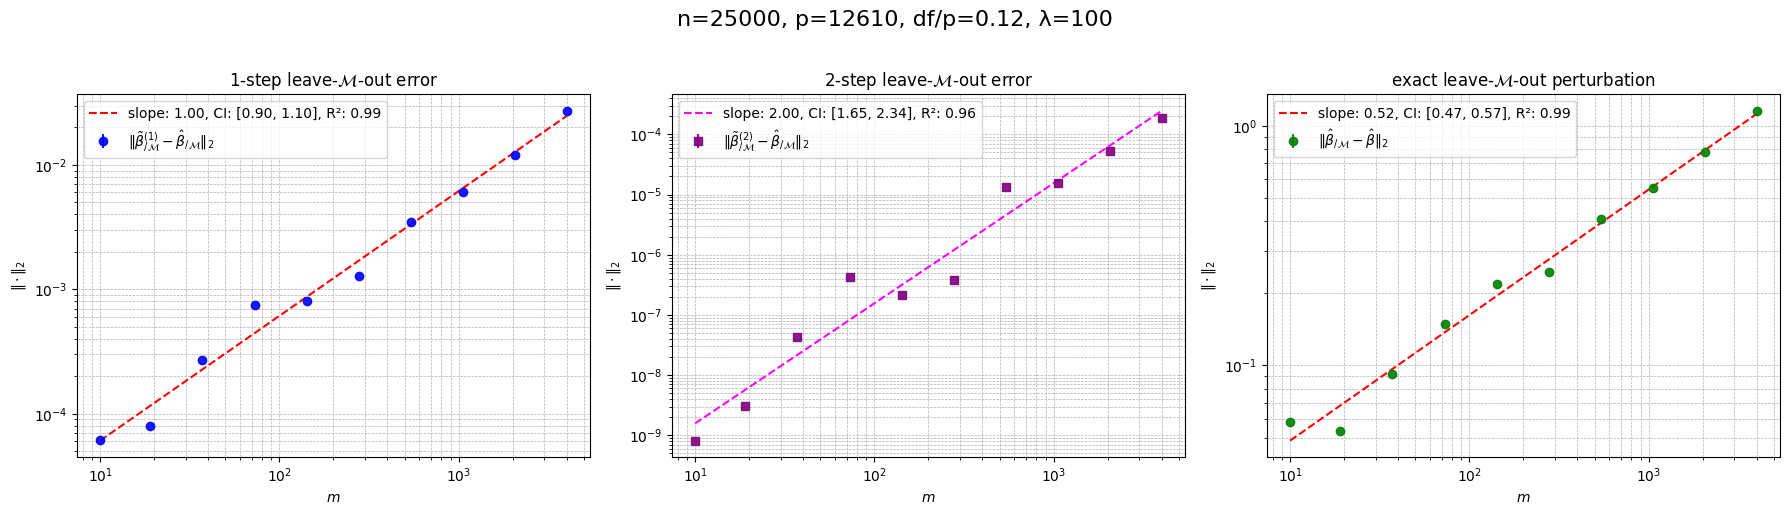

In [ ]:
# Create a 1x3 panel plot with true log-log scale and error bars
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Titles including parameters
title_text = f"n={n}, p={p}, df/p={tr_H_est:.2f}, λ={lambda_}"

# ---- Panel 1: One Newton Step Error (Tilde) ----
axes[0].errorbar(m_values, error_means_tilde, yerr=error_stds_tilde, fmt='o',
                 color='blue', alpha=0.9, label=r'$\|\tilde{\beta}^{(1)}_{/ \mathcal{M}} - \hat{\beta}_{/ \mathcal{M}}\|_2$')
axes[0].plot(m_values, np.exp(log_error_pred_tilde),
             label=f'slope: {slope_tilde:.2f}, CI: [{conf_int_tilde[0]:.2f}, {conf_int_tilde[1]:.2f}], R²: {R2_tilde:.2f}',
             color='red', linestyle='--')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\|\cdot\|_2$')
axes[0].set_title(r'1-step leave-$\mathcal{M}$-out error')# + "\n" + title_text)
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# ---- Panel 2: Two Newton Step Error (Tilde_2) ----
axes[1].errorbar(m_values, error_means_tilde_2, yerr=error_stds_tilde_2, fmt='s',
                 color='purple', alpha=0.9, label=r'$\|\tilde{\beta}^{(2)}_{/ \mathcal{M}} - \hat{\beta}_{/ \mathcal{M}}\|_2$')
axes[1].plot(m_values, np.exp(log_error_pred_tilde_2),
             label=f'slope: {slope_tilde_2:.2f}, CI: [{conf_int_tilde_2[0]:.2f}, {conf_int_tilde_2[1]:.2f}], R²: {R2_tilde_2:.2f}',
             color='magenta', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$m$')
axes[1].set_ylabel(r'$\|\cdot\|_2$')
axes[1].set_title(r'2-step leave-$\mathcal{M}$-out error')# + "\n" + title_text)
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# ---- Panel 3: Leave-M-out Perturbation (Hat) ----
axes[2].errorbar(m_values, error_means_hat, yerr=error_stds_hat, fmt='o',
                 color='green', alpha=0.9, label=r'$\|\hat{\beta}_{/ \mathcal{M}} - \hat{\beta}\|_2$')
axes[2].plot(m_values, np.exp(log_error_pred_hat),
             label=f'slope: {slope_hat:.2f}, CI: [{conf_int_hat[0]:.2f}, {conf_int_hat[1]:.2f}], R²: {R2_hat:.2f}',
             color='red', linestyle='--')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_xlabel(r'$m$')
axes[2].set_ylabel(r'$\|\cdot\|_2$')
axes[2].set_title(r'exact leave-$\mathcal{M}$-out perturbation')# + "\n" + title_text)
axes[2].legend()
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
fig.suptitle(title_text, fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
#np.savetxt("linear-noncons/elnet/lo_delta0_5p200.csv", lo, delimiter=",")
#np.savetxt("linear-noncons/elnet/outErr_delta0_5p200.csv", outErr, delimiter=",")

/tmp/ipython-input-3548325446.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


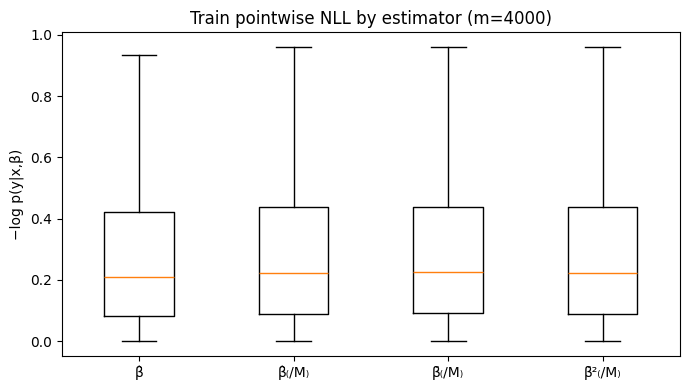

/tmp/ipython-input-3548325446.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


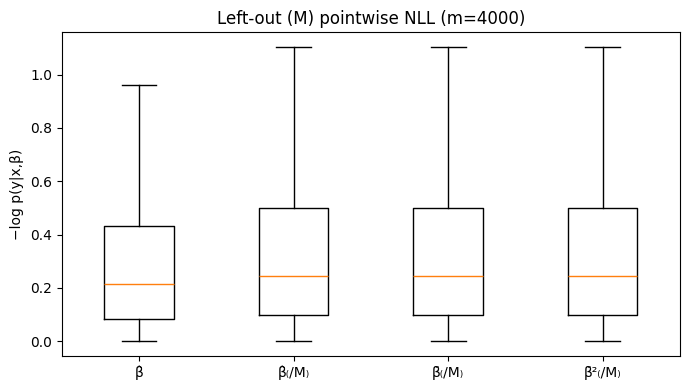

/tmp/ipython-input-3548325446.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


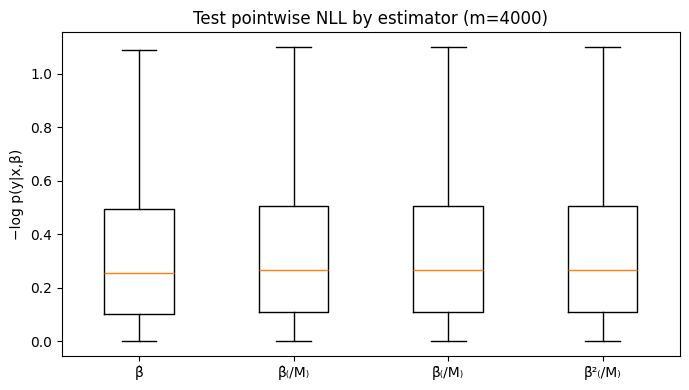

In [ ]:
def pointwise_nll(Xmat, yvec, beta):
    z = Xmat @ beta
    return np.logaddexp(0.0, z) - yvec * z

# ---- per-sample losses ----
loss_train_hat      = pointwise_nll(X, y, beta_hat)
loss_train_hat_M    = pointwise_nll(X, y, beta_hat_M_out)
loss_train_tilde    = pointwise_nll(X, y, beta_tilde_m_out)
loss_train_tilde_2  = pointwise_nll(X, y, beta_tilde_m_out_2)

# left-out (M-subset)
loss_left_hat       = pointwise_nll(X_M, y_M, beta_hat)
loss_left_hat_M     = pointwise_nll(X_M, y_M, beta_hat_M_out)
loss_left_tilde     = pointwise_nll(X_M, y_M, beta_tilde_m_out)
loss_left_tilde_2   = pointwise_nll(X_M, y_M, beta_tilde_m_out_2)

loss_test_hat       = pointwise_nll(X_test_arr, y_test_arr, beta_hat)
loss_test_hat_M     = pointwise_nll(X_test_arr, y_test_arr, beta_hat_M_out)
loss_test_tilde     = pointwise_nll(X_test_arr, y_test_arr, beta_tilde_m_out)
loss_test_tilde_2   = pointwise_nll(X_test_arr, y_test_arr, beta_tilde_m_out_2)

# ---- Boxplots: TRAIN ----
plt.figure(figsize=(7,4))
plt.boxplot(
    [loss_train_hat, loss_train_hat_M, loss_train_tilde, loss_train_tilde_2],
    labels=['β̂', 'β̂₍/M₎', 'β̃₍/M₎', 'β̃²₍/M₎'],
    showfliers=False,
)
plt.title(f'Train pointwise NLL by estimator (m={m})')
plt.ylabel('−log p(y|x,β)')
plt.tight_layout()
plt.show()

# ---- Boxplots: LEFT-OUT ----
plt.figure(figsize=(7,4))
plt.boxplot(
    [loss_left_hat, loss_left_hat_M, loss_left_tilde, loss_left_tilde_2],
    labels=['β̂', 'β̂₍/M₎', 'β̃₍/M₎', 'β̃²₍/M₎'],
    showfliers=False,
)
plt.title(f'Left-out (M) pointwise NLL (m={m})')
plt.ylabel('−log p(y|x,β)')
plt.tight_layout()
plt.show()

# ---- Boxplots: TEST ----
plt.figure(figsize=(7,4))
plt.boxplot(
    [loss_test_hat, loss_test_hat_M, loss_test_tilde, loss_test_tilde_2],
    labels=['β̂', 'β̂₍/M₎', 'β̃₍/M₎', 'β̃²₍/M₎'],
    showfliers=False,
)
plt.title(f'Test pointwise NLL by estimator (m={m})')
plt.ylabel('−log p(y|x,β)')
plt.tight_layout()
plt.show()


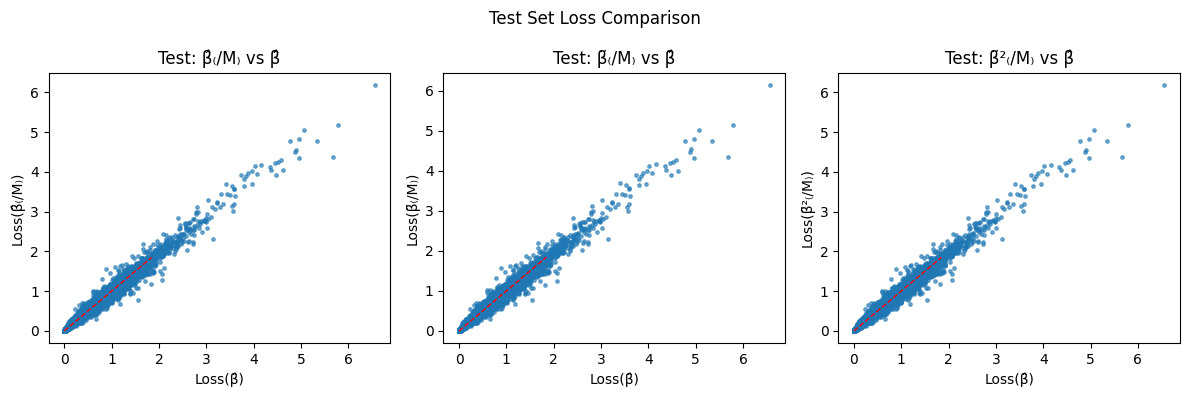

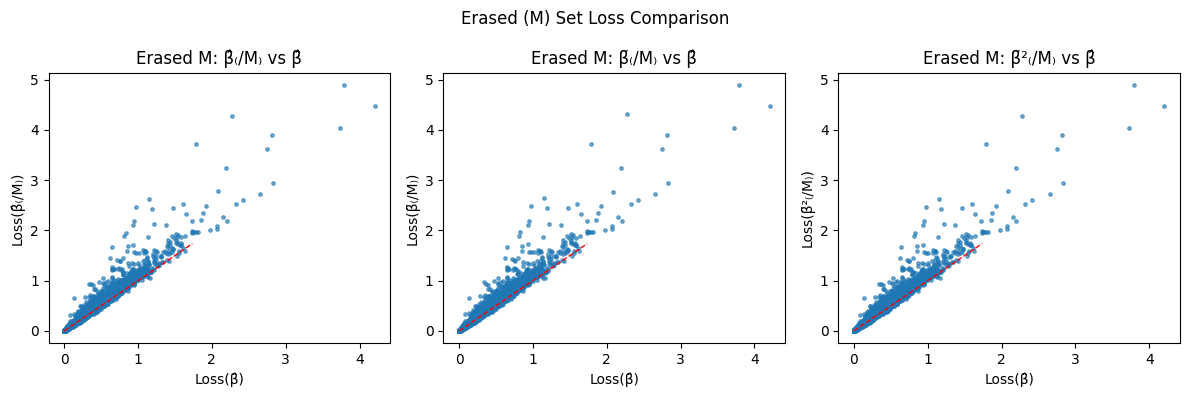

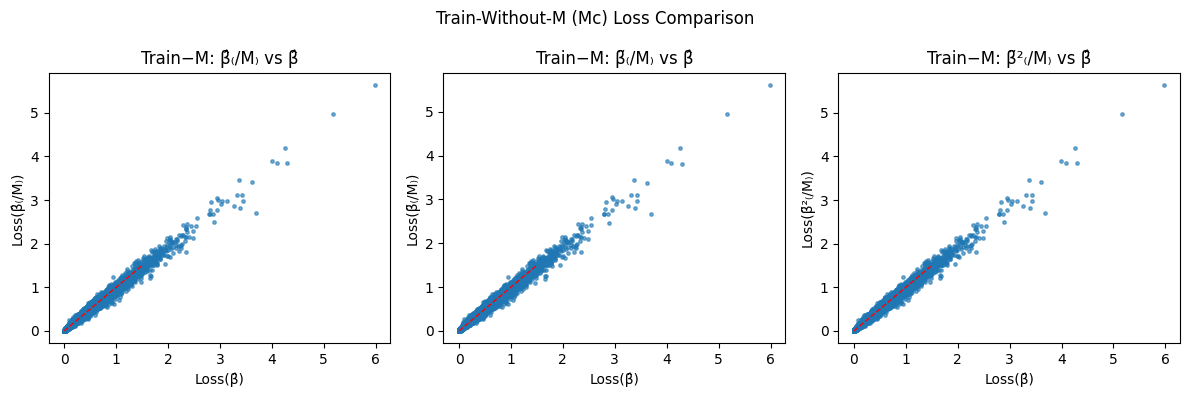

In [ ]:
# ---- Compute per-sample losses on erased and remaining sets ----
loss_erase_hat      = pointwise_nll(X_M,  y_M,  beta_hat)
loss_erase_hat_M    = pointwise_nll(X_M,  y_M,  beta_hat_M_out)
loss_erase_tilde    = pointwise_nll(X_M,  y_M,  beta_tilde_m_out)
loss_erase_tilde_2  = pointwise_nll(X_M,  y_M,  beta_tilde_m_out_2)

loss_erasec_hat      = pointwise_nll(X_Mc,  y_Mc,  beta_hat)
loss_erasec_hat_M    = pointwise_nll(X_Mc,  y_Mc,  beta_hat_M_out)
loss_erasec_tilde    = pointwise_nll(X_Mc,  y_Mc,  beta_tilde_m_out)
loss_erasec_tilde_2  = pointwise_nll(X_Mc,  y_Mc,  beta_tilde_m_out_2)

# ---- Scatter Plot Utility ----
def scatter_loss_comparison(loss_ref, loss_alt, label_ref, label_alt, title):
    plt.scatter(loss_ref, loss_alt, s=6, alpha=0.6)
    minv, maxv = np.percentile(np.hstack([loss_ref, loss_alt]), [1, 99])
    plt.plot([minv, maxv], [minv, maxv], 'r--', lw=1)
    plt.xlabel(f'Loss({label_ref})')
    plt.ylabel(f'Loss({label_alt})')
    plt.title(title)
    plt.tight_layout()

# ---- TEST LOSSES ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
scatter_loss_comparison(loss_test_hat, loss_test_hat_M, 'β̂', 'β̂₍/M₎', 'Test: β̂₍/M₎ vs β̂')
plt.subplot(1, 3, 2)
scatter_loss_comparison(loss_test_hat, loss_test_tilde, 'β̂', 'β̃₍/M₎', 'Test: β̃₍/M₎ vs β̂')
plt.subplot(1, 3, 3)
scatter_loss_comparison(loss_test_hat, loss_test_tilde_2, 'β̂', 'β̃²₍/M₎', 'Test: β̃²₍/M₎ vs β̂')
plt.suptitle('Test Set Loss Comparison')
plt.tight_layout()
plt.show()

# ---- ERASED (M) SET LOSSES ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
scatter_loss_comparison(loss_erase_hat, loss_erase_hat_M, 'β̂', 'β̂₍/M₎', 'Erased M: β̂₍/M₎ vs β̂')
plt.subplot(1, 3, 2)
scatter_loss_comparison(loss_erase_hat, loss_erase_tilde, 'β̂', 'β̃₍/M₎', 'Erased M: β̃₍/M₎ vs β̂')
plt.subplot(1, 3, 3)
scatter_loss_comparison(loss_erase_hat, loss_erase_tilde_2, 'β̂', 'β̃²₍/M₎', 'Erased M: β̃²₍/M₎ vs β̂')
plt.suptitle('Erased (M) Set Loss Comparison')
plt.tight_layout()
plt.show()

# ---- TRAIN WITHOUT M (Mc) LOSSES ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
scatter_loss_comparison(loss_erasec_hat, loss_erasec_hat_M, 'β̂', 'β̂₍/M₎', 'Train−M: β̂₍/M₎ vs β̂')
plt.subplot(1, 3, 2)
scatter_loss_comparison(loss_erasec_hat, loss_erasec_tilde, 'β̂', 'β̃₍/M₎', 'Train−M: β̃₍/M₎ vs β̂')
plt.subplot(1, 3, 3)
scatter_loss_comparison(loss_erasec_hat, loss_erasec_tilde_2, 'β̂', 'β̃²₍/M₎', 'Train−M: β̃²₍/M₎ vs β̂')
plt.suptitle('Train-Without-M (Mc) Loss Comparison')
plt.tight_layout()
plt.show()


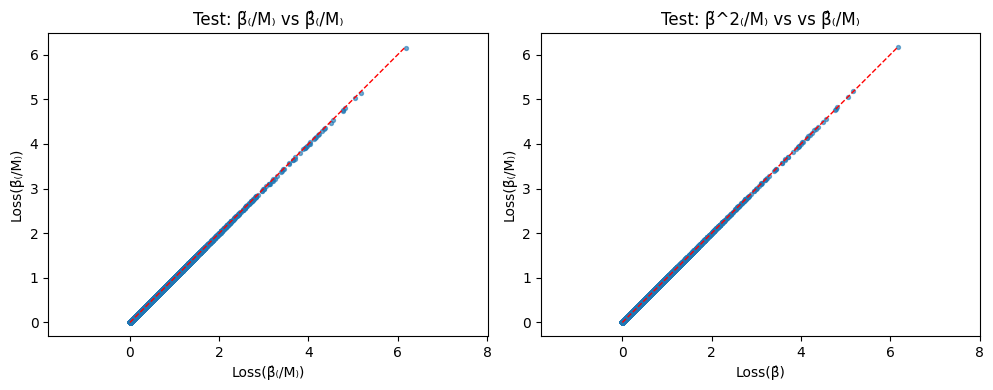

In [ ]:
# ---- Scatter plots of TEST losses ----
plt.figure(figsize=(10, 4))

# First: β̃₍/M₎ vs β̂₍/M₎
plt.subplot(1, 2, 1)
x1, y1 = loss_test_hat_M, loss_test_tilde
plt.scatter(x1, y1, s=8, alpha=0.6)
minv, maxv = np.min([x1.min(), y1.min()]), np.max([x1.max(), y1.max()])
plt.plot([minv, maxv], [minv, maxv], 'r--', lw=1)
plt.xlabel('Loss(β̂₍/M₎)')
plt.ylabel('Loss(β̃₍/M₎)')
plt.title('Test: β̃₍/M₎ vs β̂₍/M₎')
plt.axis('equal')

# Second: β̃2₍/M₎ vs β̂₍/M₎
plt.subplot(1, 2, 2)
x2, y2 = loss_test_hat_M, loss_test_tilde_2
plt.scatter(x2, y2, s=8, alpha=0.6)
minv, maxv = np.min([x2.min(), y2.min()]), np.max([x2.max(), y2.max()])
plt.plot([minv, maxv], [minv, maxv], 'r--', lw=1)
plt.xlabel('Loss(β̂)')
plt.ylabel('Loss(β̃₍/M₎)')
plt.title('Test: β̃^2₍/M₎ vs vs β̂₍/M₎')
plt.axis('equal')

plt.tight_layout()
plt.show()
